In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### IMPORTS

In [2]:
# feature engineering libs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# sklearn 
import sklearn
from sklearn.model_selection import train_test_split

# tensorflow related libs
import tensorflow as tf
from tensorflow.keras.layers import IntegerLookup, Normalization, StringLookup 

import datetime

In [3]:
pd.set_option('display.max_rows', 500)

### HELPER FUNCTIONS

In [4]:
def create_model_checkpoint(model_name, save_path="model_experiment"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name), 
        verbose=1, 
        save_best_only=True,
        monitor='val_loss',
    )

In [5]:
def dataframe_to_dataset (dataframe, is_test):
    data_frame = dataframe.copy()
    if is_test:
        ds = tf.data.Dataset.from_tensors(dict(data_frame))
    else:    
        labels = data_frame.pop("Survived")
        ds = tf.data.Dataset.from_tensor_slices((dict(data_frame), labels))
        ds = ds.shuffle(buffer_size=len(data_frame))
    return ds

In [6]:
def encode_numerical_feature (feature, name, dataset):
    normalizer = Normalization()
    
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

In [7]:
def encode_categorical_feature (feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class(output_mode="binary")
    
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    lookup.adapt(feature_ds)
    encoded_feature = lookup(feature)
    return encoded_feature

In [8]:
def age_binning(age):
    
    if age < 10:
        return "child"
    elif (age >= 10) & ( age <= 18):
        return "teen"
    elif (age >= 18) & (age <= 30):
        return "adult"
    elif (age >= 30) & (age <= 50):
        return "senior"
    elif age >= 50:
        return "old"
    else:
        return "missing"

In [9]:
def fare_binning(fare):
    
    if fare < 10:
        return "class_1"
    elif (fare >= 10) & ( fare <= 50):
        return "class_2"
    elif (fare >= 50) & (fare <= 100):
        return "class_3"
    elif (fare >= 100) & (fare <= 200):
        return "class_4"
    elif (fare >= 200) & (fare <= 350):
        return "class_4"
    elif fare >= 350:
        return "class_5"
    else:
        print(fare)
        return "missing"

In [10]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

### MANAGING DATA

[https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook](http://)

In [11]:
# Imports dataset from Kaggle
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
len(train_df), len(test_df), train_df.shape, test_df.shape

(891, 418, (891, 12), (418, 11))

In [12]:
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### CLEANING DATA

In [13]:
print(train_df.isna().sum())
print(test_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [14]:
# Filling age column missing values
train_df["Age"] = train_df.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))
test_df["Age"] = test_df.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))

# Filling embarked column missing values
train_df["Embarked"] = train_df["Embarked"].fillna('S')
test_df["Embarked"] = test_df["Embarked"].fillna('S')

# Filling fare column missing values
median_fare_value = train_df.groupby(["Pclass", "SibSp", "Parch"])["Fare"].median()[3][0][0]
train_df["Fare"] = train_df["Fare"].fillna(median_fare_value)
test_df["Fare"] = test_df["Fare"].fillna(median_fare_value)

# Creating deck column based on cabin column
train_df["Deck"] = train_df["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')
test_df["Deck"] = test_df["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')

train_df["Deck"] = train_df["Deck"].replace(['A','B','C', 'T'], 'ABC')
train_df["Deck"] = train_df["Deck"].replace(['D','E'], 'DE')
train_df["Deck"] = train_df["Deck"].replace(['F','G'], 'FG')
 
test_df["Deck"] = test_df["Deck"].replace(['A','B','C', 'T'], 'ABC')
test_df["Deck"] = test_df["Deck"].replace(['D','E'], 'DE')
test_df["Deck"] = test_df["Deck"].replace(['F','G'], 'FG')

# Replacing passenger id as index
train_df.set_index(keys="PassengerId", inplace=True)
test_df.set_index(keys="PassengerId", inplace=True)

In [15]:
# Binning continous features
train_df["Fare"] = train_df["Fare"].apply(fare_binning)
test_df["Fare"] = test_df["Fare"].apply(fare_binning)

train_df["Age"] = train_df["Age"].apply(age_binning)
test_df["Age"] = test_df["Age"].apply(age_binning)

In [16]:
# Frequency Encoding
train_df["Family_Size"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["Family_Size"] = test_df["SibSp"] + test_df["Parch"] + 1

train_df["Ticket_Frequency"] = train_df.groupby("Ticket")["Ticket"].transform('count')
test_df["Ticket_Frequency"] = test_df.groupby("Ticket")["Ticket"].transform('count')



In [17]:
# Title & IsMaried
train_df['Title'] = train_df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
train_df['Is_Maried'] = np.where(train_df["Title"] == 'Mrs', 1,0)

test_df["Title"] = test_df["Name"].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
test_df["Is_Maried"] = np.where(test_df["Title"] == 'Mrs', 1,0)

train_df["Title"] = train_df["Title"].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
train_df["Title"] = train_df["Title"].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'],'Dr/Military/Noble/Clergy')
test_df["Title"] = test_df["Title"].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'],'Miss/Mrs/Ms')
test_df["Title"] = test_df["Title"].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'],'Dr/Military/Noble/Clergy')

In [18]:
# Drop unused features
train_df.drop(["Name", "SibSp", "Parch", "Ticket", "Cabin"], axis=1, inplace=True)
test_df.drop(["Name", "SibSp", "Parch", "Ticket", "Cabin"], axis=1, inplace=True)

In [19]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Family_Size,Ticket_Frequency,Title,Is_Maried
PassengerId,,,,,,,,,,,
1,0,3,male,adult,class_1,S,M,2,1,Mr,0
2,1,1,female,senior,class_3,C,ABC,2,1,Miss/Mrs/Ms,1
3,1,3,female,adult,class_1,S,M,1,1,Miss/Mrs/Ms,0
4,1,1,female,senior,class_3,S,ABC,2,2,Miss/Mrs/Ms,1
5,0,3,male,senior,class_1,S,M,1,1,Mr,0


In [20]:
# Creating training and validation sets
validation_set = train_df.sample(frac=0.2, random_state=883)
training_set = train_df.drop(validation_set.index)

# Turning dataframe into dataset
train_dataset = dataframe_to_dataset(training_set, False)
val_dataset = dataframe_to_dataset(validation_set, False)
test_dataset = dataframe_to_dataset(test_df, True)

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# this line was commented in the other kernel as well
# test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

2022-10-14 17:23:42.499694: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### CREATE MODEL

Binary Classification Model to Structured Data
[https://keras.io/examples/structured_data/structured_data_classification_from_scratch/](http://)

In [21]:
# categorical feature encoding as string
sex = tf.keras.Input(shape=(1,), name="Sex", dtype=tf.string)
age = tf.keras.Input(shape=(1,), name="Age", dtype=tf.string)
fare = tf.keras.Input(shape=(1,), name="Fare", dtype=tf.string)
embarked = tf.keras.Input(shape=(1,), name="Embarked", dtype=tf.string)
deck = tf.keras.Input(shape=(1,), name="Deck", dtype=tf.string)
title = tf.keras.Input(shape=(1,), name="Title", dtype=tf.string)

# categorical feature encoding as integer
pclass = tf.keras.Input(shape=(1,), name="Pclass", dtype=tf.int64)
family_size = tf.keras.Input(shape=(1,), name="Family_Size", dtype=tf.int64)
ticket_freq = tf.keras.Input(shape=(1,), name="Ticket_Frequency", dtype=tf.int64)
is_maried = tf.keras.Input(shape=(1,), name="Is_Maried", dtype=tf.int64)

In [22]:
# creating an input variable contianer to feed the model as input list
all_inputs = [
    sex,
    age,
    fare,
    embarked,
    deck,
    title,
    pclass,
    family_size,
    ticket_freq,
    is_maried
]

In [23]:
dp_value = 0.4

In [24]:
sex_encoded = encode_categorical_feature(sex, "Sex", train_dataset, True)
sex_embedded = tf.keras.layers.Embedding(input_dim=3, output_dim=3, name='sex_embedding')(sex_encoded)
sex_encoded = tf.keras.layers.Flatten()(sex_embedded)
sex_encoded = tf.keras.layers.Dropout(dp_value)(sex_encoded)

age_encoded = encode_categorical_feature(age, "Age", train_dataset, True)
age_embedded = tf.keras.layers.Embedding(input_dim=5, output_dim=5, name='age_embedding' )(age_encoded)
age_encoded = tf.keras.layers.Flatten()(age_embedded)
age_encoded = tf.keras.layers.Dropout(dp_value)(age_encoded)

fare_encoded = encode_categorical_feature(fare, "Fare", train_dataset, True)
fare_embedding = tf.keras.layers.Embedding(input_dim=6, output_dim=6, name='fare_emedding')(fare_encoded)
fare_encoded = tf.keras.layers.Flatten()(fare_embedding)
fare_encoded = tf.keras.layers.Dropout(dp_value)(fare_encoded)

embarked_encoded = encode_categorical_feature(embarked, "Embarked", train_dataset, True)
embarked_embedding = tf.keras.layers.Embedding(input_dim=4, output_dim=4, name="embarked_encoded")(embarked_encoded)
embarked_encoded = tf.keras.layers.Flatten()(embarked_embedding)
embarked_encoded = tf.keras.layers.Dropout(dp_value)(embarked_encoded)

deck_encoded = encode_categorical_feature(deck, "Deck", train_dataset, True)
deck_embedding = tf.keras.layers.Embedding(4,4)(deck_encoded)
deck_encoded = tf.keras.layers.Flatten()(deck_embedding)
deck_encoded = tf.keras.layers.Dropout(dp_value)(deck_encoded)

title_encoded = encode_categorical_feature(title, "Title", train_dataset, True)
title_embedding = tf.keras.layers.Embedding(5,5)(title_encoded)
title_encoded = tf.keras.layers.Flatten()(title_embedding)
title_encoded = tf.keras.layers.Dropout(dp_value)(title_encoded)

2022-10-14 17:23:42.932731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [25]:
pclass_encoded = encode_categorical_feature(pclass, "Pclass", train_dataset, False)
pclass_embedding = tf.keras.layers.Embedding(4,4)(pclass_encoded)
pclass_encoded = tf.keras.layers.Flatten()(pclass_embedding)
pclass_encoded = tf.keras.layers.Dropout(dp_value)(pclass_encoded)

family_size_encoded = encode_categorical_feature(family_size, "Family_Size", train_dataset, False)
family_size_embedding = tf.keras.layers.Embedding(10,10)(family_size_encoded)
family_size_encoded = tf.keras.layers.Flatten()(family_size_embedding)
family_size_encoded = tf.keras.layers.Dropout(dp_value)(family_size_encoded)

ticket_freq_encoded = encode_categorical_feature(ticket_freq, "Ticket_Frequency", train_dataset, False)
ticket_freq_embedding = tf.keras.layers.Embedding(8,8)(ticket_freq_encoded)
ticket_freq_encoded = tf.keras.layers.Flatten()(ticket_freq_embedding)
ticket_freq_encoded = tf.keras.layers.Dropout(dp_value)(ticket_freq_encoded)

# is_maried_encoded = encode_categorical_feature(is_maried, "Is_Maried", train_dataset, False)
# is_maried_embedding = tf.keras.layers.Embedding(3,3)(is_maried_encoded)
# is_maried_encoded = tf.keras.layers.Flatten()(is_maried_embedding)
# is_maried_encoded = tf.keras.layers.Dropout(0.2)(is_maried_encoded)

In [26]:
all_features = tf.keras.layers.concatenate([
    sex_encoded,
    age_encoded,
    fare_encoded,
    embarked_encoded,
    deck_encoded,
    title_encoded,
    pclass_encoded,
    family_size_encoded,
    ticket_freq_encoded,
#     is_maried_encoded
])

In [27]:
# model with relu activations
relu_model = tf.keras.layers.Dense(
        64, 
        activation=tf.keras.activations.relu,
        kernel_regularizer='l1_l2'
    )(all_features)
relu_model = tf.keras.layers.Dense(
        32, 
        activation=tf.keras.activations.relu,
    )(relu_model)
relu_model = tf.keras.layers.Dropout(0.2)(relu_model)

# create output and model
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(relu_model)
model = tf.keras.Model(all_inputs, output)

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0009),
    metrics=["accuracy"],
    loss=tf.keras.losses.binary_crossentropy
)

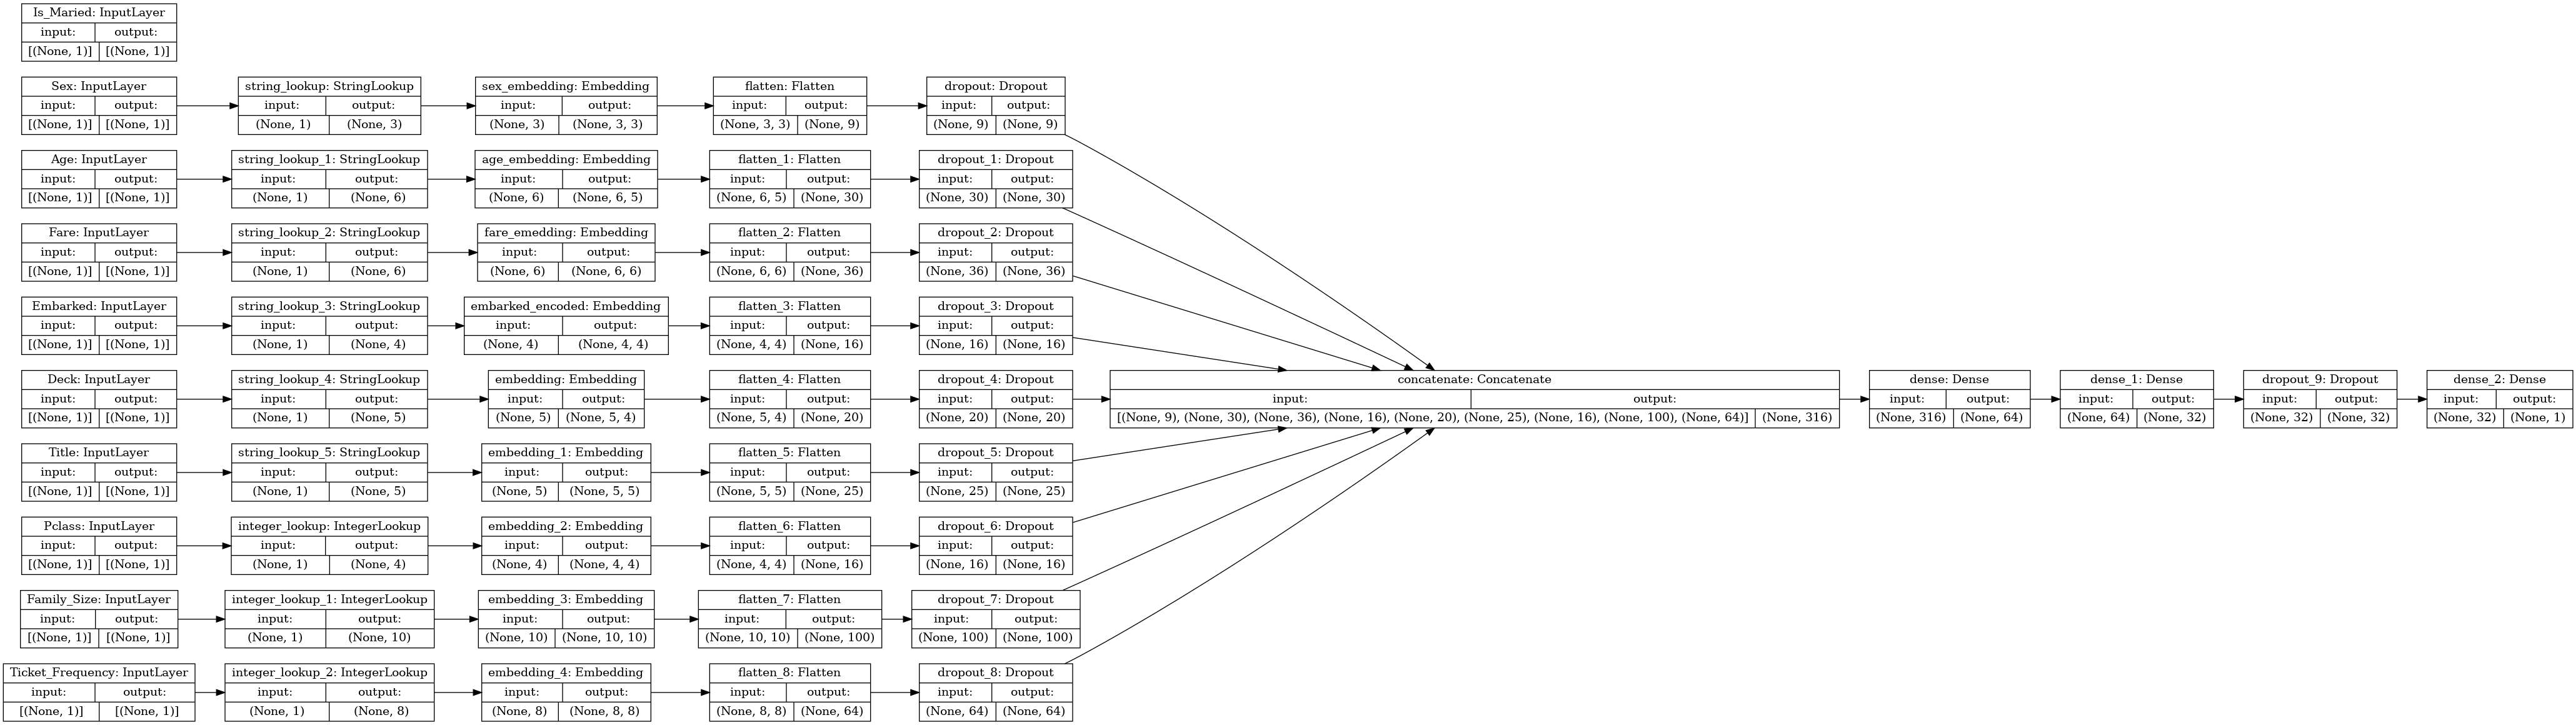

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [30]:
model_hist = model.fit(
    train_dataset, 
    epochs=500, 
    validation_data=val_dataset, 
    callbacks=[create_model_checkpoint("model", 'simple')] 
)

Epoch 1/500
23/23 [==============================] - 4s 31ms/step - loss: 12.3517 - accuracy: 0.6045 - val_loss: 10.1436 - val_accuracy: 0.6067

Epoch 00001: val_loss improved from inf to 10.14359, saving model to simple/model


2022-10-14 17:23:51.826449: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 8.5000 - accuracy: 0.6185 - val_loss: 6.7629 - val_accuracy: 0.6067

Epoch 00002: val_loss improved from 10.14359 to 6.76295, saving model to simple/model
Epoch 3/500
23/23 [==============================] - 0s 7ms/step - loss: 5.4990 - accuracy: 0.6185 - val_loss: 4.1984 - val_accuracy: 0.6067

Epoch 00003: val_loss improved from 6.76295 to 4.19843, saving model to simple/model
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 3.2887 - accuracy: 0.6185 - val_loss: 2.3877 - val_accuracy: 0.6067

Epoch 00004: val_loss improved from 4.19843 to 2.38766, saving model to simple/model
Epoch 5/500
23/23 [==============================] - 0s 7ms/step - loss: 1.7944 - accuracy: 0.6185 - val_loss: 1.2589 - val_accuracy: 0.6067

Epoch 00005: val_loss improved from 2.38766 to 1.25891, saving model to simple/model
Epoch 6/500
23/23 [==============================] - 0s 7ms/step - loss: 0.9483 - accuracy:

In [31]:
# pick the best model and evaluate on validatation data
model_best = tf.keras.models.load_model("./simple/model")
model_best.evaluate(val_dataset)


6/6 [==============================] - 1s 4ms/step - loss: 0.5249 - accuracy: 0.8090


[0.5248664617538452, 0.8089887499809265]

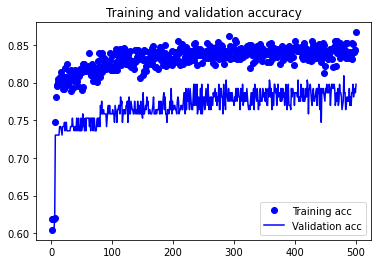

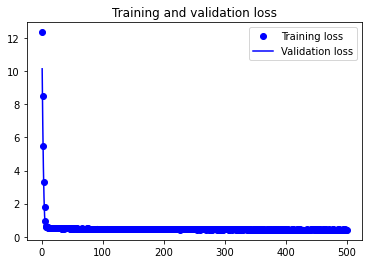

In [32]:
val_loss = model_hist.history['val_loss']
loss = model_hist.history['loss']
acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
# create predictions on test data
model_preds = model_best.predict(test_dataset)
model_preds = tf.cast(np.round(np.max(model_preds, axis=1)), dtype=tf.int32)

In [34]:
output = pd.DataFrame({"PassengerId": test_df.index, "Survived": model_preds})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
